## Goal : check shear SNR prediction vs CLMM mock data

In [1]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy import stats, interpolate

import sys
sys.path.append('../')
import magnification_library as magnification_library
from magnification_library import *

import clmm
import clmm.support.mock_data as mock
import pyccl

from importlib import reload  

In [2]:
clmm.__version__

'1.0.0'

In [3]:
reload(magnification_library)

<module 'magnification_library' from '../magnification_library.py'>

In [4]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [7]:
#computation utils properties
z_s = np.linspace(0.001, 4, 1000)
zinf = 1000 


### Source / lens properties

In [55]:
#Source galaxies properties 
#(source shear shot noise or LF slope, source density, redshift distribution parametrization)


#MAGNIFICATION LSST u-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

#At z~3 the LSST band corresponding to UV ~ 1500 Angstrom is the r band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlim = 25.495 #i band

alpha_lbg = 3.321

n_eff_lbg = 0.54/(u.arcmin*u.arcmin)

def mu_lbg_pdz(z):
    func = gaussian(z, 1, 2.6, 1/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.6,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]

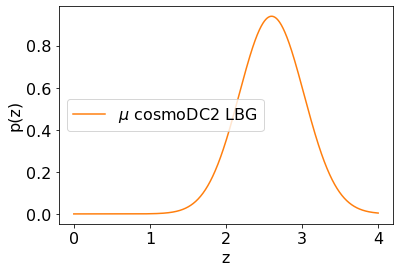

In [56]:
plt.plot(z_s, mu_lbg_pdz(z_s), 'C1',  label = '$\mu$ cosmoDC2 LBG')

plt.xlabel('z')
plt.ylabel("p(z)")
plt.legend();

In [113]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

In [122]:
#Lens properties

cluster_m = 0.5e14
cluster_z = 0.5
N_cl = 2158
Delta = 200 # mass definition with respect to critical overdensity
concentration = get_halo_concentration(cluster_m, cluster_z, cosmo_clmm.be_cosmo, "Diemer15", "matter", Delta )
print("concentration =", concentration)

concentration = 4.079282119886581


## - Model construction

In [130]:
radial_unit, rmin, rmax, nbins, method = 'Mpc', 0.1, 7, 100, 'evenlog10width'
binedges = clmm.utils.make_bins(rmin, rmax, nbins=nbins, method=method)

In [131]:
dict_profile = {'density contrast': \
                {'model_func':  clmm.theory.compute_convergence, \
                'noise_func': noise_mag,\
                'model_arg': 2 * abs(alpha_lbg-1), \
                'source_pdz': mu_lbg_pdz,\
                'source_density': n_eff_lbg,\
                'delta_z_cut' : 0.1},
                'density contrast 2': \
                {'model_func':  clmm.theory.compute_magnification, \
                'noise_func': noise_mag,\
                'model_arg': 1, \
                'source_pdz': mu_lbg_pdz,\
                'source_density': n_eff_lbg,\
                'delta_z_cut' : 0.1}}


In [132]:
lens_redshift = cluster_z
profile_type = "density contrast"

In [133]:
bin_center, bin_edges, noise, model = profile_determination(rmin, rmax, radial_unit , lens_redshift, cluster_m , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)
bin_center, binedges, Ngal = compute_source_number_per_bin(rmin, rmax, radial_unit, lens_redshift, dict_profile[profile_type]['source_pdz'], dict_profile[profile_type]['source_density'], nbins, method, cosmo_clmm)

In [140]:
rad_Mpc = utils.convert_units(bin_center, radial_unit, 'Mpc', lens_redshift, cosmo_clmm)
zmin, zmax, nz = 0.001, 5, 10000

zint = np.linspace(zmin, zmax, nz)
zrand = np.random.choice(zint, 1000, p=mu_lbg_pdz(zint)/np.sum(mu_lbg_pdz(zint)))

model_z = np.zeros((rad_Mpc.size))  
                
for i in range(rad_Mpc.size):
    model_z[i] = np.mean(dict_profile["density contrast 2"]['model_func'](rad_Mpc[i], mdelta=cluster_m, 
                                                    cdelta=concentration, z_cluster=lens_redshift, z_source=2.6, 
                                                    cosmo= cosmo_clmm, 
                                                    delta_mdef=200, 
                                                    halo_profile_model='nfw', 
                                                    z_src_model='single_plane')**(dict_profile[profile_type]['model_arg']-1)) - 1

## - Noise contribution from the profile construction

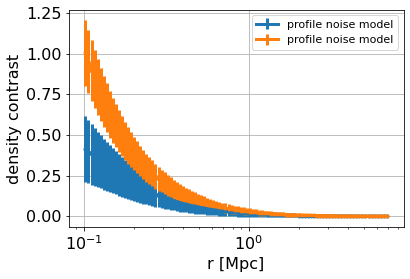

In [141]:
plt.errorbar(bin_center, model, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center],fmt='.-', lw=3,\
             label='profile noise model', yerr = noise/np.sqrt(N_cl))

plt.errorbar(bin_center, model_z, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center],fmt='.-', lw=3,\
             label='profile noise model', yerr = noise/np.sqrt(N_cl))


#plt.ylim(0)
plt.grid()
plt.xscale('log')

plt.legend(fontsize='x-small')

plt.ylabel(profile_type)
plt.xlabel('r [' + radial_unit + ']');